## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtra (np. 21).

2. Stwórz okno np. Hamminga (`np.Hmming`) o zadanym rozmiarze.

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:
        hanning2d = np.outer(hanning, hanning)

4. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.

5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.

        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

--2021-01-22 16:46:47--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/literki.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.64.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66616 (65K) [image/bmp]
Saving to: 'literki.bmp'

     0K .......... .......... .......... .......... .......... 76% 1,52M 0s
    50K .......... .....                                      100% 4,35M=0,04s

2021-01-22 16:46:48 (1,79 MB/s) - 'literki.bmp' saved [66616/66616]

--2021-01-22 16:46:48--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/wzorA.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.64.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request s

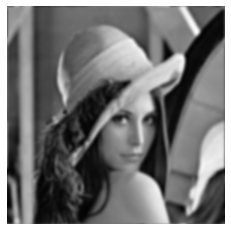

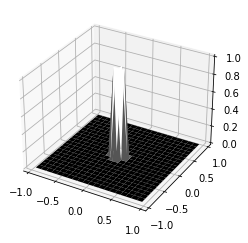

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

# Load required files
if not os.path.exists("literki.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/literki.bmp --no-check-certificate
if not os.path.exists("wzorA.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/wzorA.bmp --no-check-certificate
if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/lena.bmp --no-check-certificate

I_literki = cv2.imread("literki.bmp", cv2.IMREAD_GRAYSCALE)
I_wzorA = cv2.imread("wzorA.bmp", cv2.IMREAD_GRAYSCALE)
I_lena = cv2.imread("lena.bmp", cv2.IMREAD_GRAYSCALE)

rozmiar_filtra = 21
hanning = np.hamming(rozmiar_filtra)
hanning2d = np.outer(hanning, hanning) # tab 21x21

# wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu:
FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(rozmiar_filtra))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, rozmiar_filtra])) # znormalizowana macierz częstotliwości
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(rozmiar_filtra))
FSpaceColsM = np.outer(np.ones([1, rozmiar_filtra]), FSpaceCols) # znormalizowana macierz częstotliwości
FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))
R = 0.1
FilterF = FreqR <= R

# odwrotna transformata Fouriera filtru idealnego:
FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3), flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

# poprawny filtr:
FilterFI = FilterFI * hanning2d

# przeniesienie filtru do dziedziny częstotliwości:
FilterFI_copyMakeBorder = cv2.copyMakeBorder(FilterFI, 0, I_lena.shape[0] - FilterFI.shape[0], 0, I_lena.shape[1] - FilterFI.shape[1], cv2.BORDER_CONSTANT, value=0)
FilterFI_copyMakeBorder_dft = cv2.dft(np.float32(FilterFI_copyMakeBorder), flags=cv2.DFT_COMPLEX_OUTPUT)
# FilterFI_copyMakeBorder_dft = np.fft.fft(FilterFI_copyMakeBorder)
FilterFI_copyMakeBorder_fftshift = np.fft.fftshift(FilterFI_copyMakeBorder_dft, [0,1])
# FilterFI_copyMakeBorder_fftshift = np.abs(FilterFI_copyMakeBorder_fftshift)
FilterFI_copyMakeBorder_fftshift = cv2.magnitude(FilterFI_copyMakeBorder_fftshift[:, :, 0], FilterFI_copyMakeBorder_fftshift[:, :, 1])
Filter_final = np.repeat(FilterFI_copyMakeBorder_fftshift[:, :, np.newaxis], 2, axis=2)

# filtrację obrazu lena.bmp za pomocą zaprojektowanego filtra:
I_lena_dft = cv2.dft(np.float32(I_lena), flags=cv2.DFT_COMPLEX_OUTPUT)
I_lena_fftshift = np.fft.fftshift(I_lena_dft, [0,1])

wynik = I_lena_fftshift * Filter_final
wynik = np.fft.ifftshift(wynik, [0, 1])
wynik_f = cv2.idft(wynik)
wynik_f = cv2.magnitude(wynik_f[:, :, 0], wynik_f[:, :, 1])

plt.imshow(wynik_f, 'gray')
plt.axis('off')
plt.show()

figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterF, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
figFilter.show()